## Introduction
I have been trying to learn time series forecasting through Rob Hyndman's ebook 'Forecasting: Principles and Practice'. I've been focussing on the 'principles' part so far. Here's the practice.
This is my first time series forecasting project, so any suggestions/comments are welcome!

In [1]:
#library(tidyverse) # metapackage with lots of helpful functions
#list.files(path = "../input/historical-hourly-weather-data/")
#list.files(path = "../input/hourly-energy-consumption/")

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click to toggle viewing code">
 </form>'
)

In order to not complicate things too much, I'm going to select only one time series from this dataset. I'm selecting the power consumption for the Duquesne Light Company, which operates primarily in Pittsburgh and surrounding areas, as seen [here](http://slideplayer.com/4238181/14/images/4/PJM+Evolution.jpg).

## Visualising the Time Series
To begin, I'm gonna read in the data, manipulate it a little and visualise the time series. For ease of visualisation and minimising the processing time required, I'm restricting the data to 2012-17.

In [4]:
duq <- read.csv('/home/ab/Downloads/Datasets for analysis/hourly-energy-consumption-forecasting/duq.csv', stringsAsFactors = F)
head(duq,10)
duq$Datetime <- as.POSIXct(duq$Datetime, '%Y-%m-%d %H:%M:%S', tz = "EDT")
duq <- duq[duq$Datetime >= '2012-10-01 00:00:00' & duq$Datetime <= '2017-09-30 00:00:00',]
library(ggplot2)

Datetime,DUQ_MW
2012-12-31 01:00:00,1556
2012-12-31 02:00:00,1509
2012-12-31 03:00:00,1479
2012-12-31 04:00:00,1468
2012-12-31 05:00:00,1488
2012-12-31 06:00:00,1543
2012-12-31 07:00:00,1638
2012-12-31 08:00:00,1720
2012-12-31 09:00:00,1732
2012-12-31 10:00:00,1767


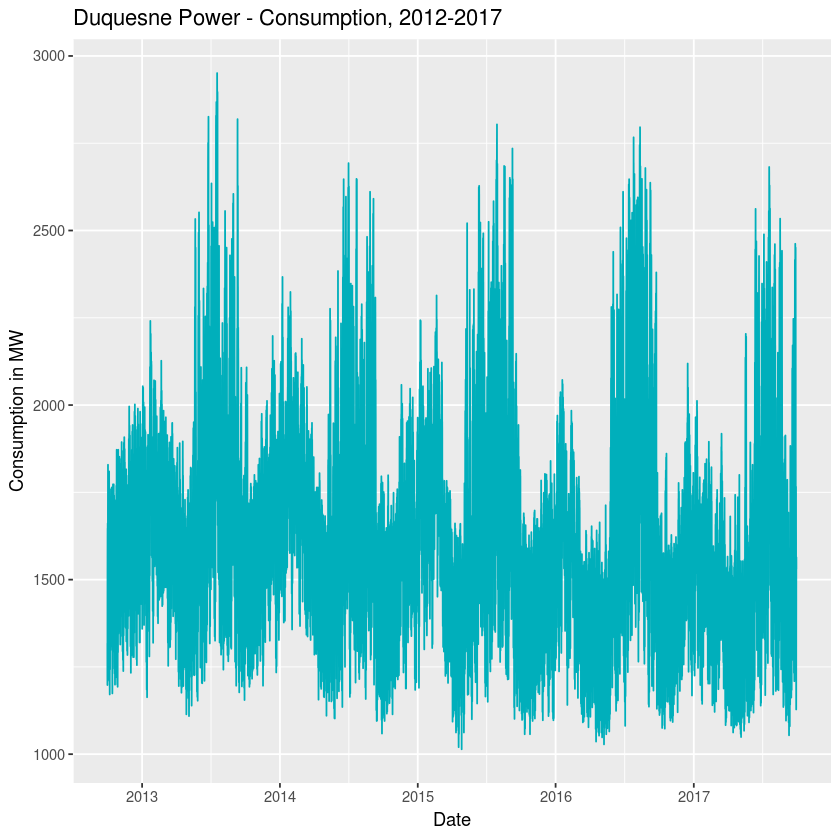

In [4]:
ggplot(data = duq, aes(x = Datetime, y = DUQ_MW))+
      geom_line(color = "#00AFBB", size = 0.5) + ggtitle('Duquesne Power - Consumption, 2012-2017')+
    xlab('Date') + ylab('Consumption in MW')

In order to visualise the seasonality of the series a bit better, here's a look at the power consumption for just 2014:

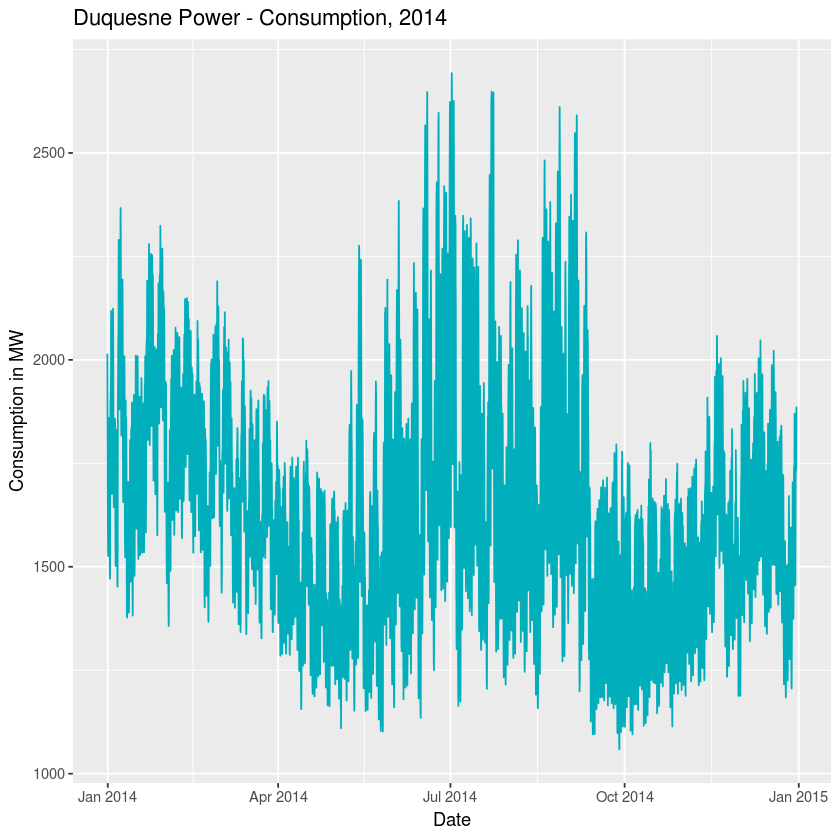

In [5]:
ggplot(data = duq[duq$Datetime >= '2014-01-01' & duq$Datetime <= '2014-12-31',], aes(x = Datetime, y = DUQ_MW))+
      geom_line(color = "#00AFBB", size = 0.5) + ggtitle('Duquesne Power - Consumption, 2014')+
    xlab('Date') + ylab('Consumption in MW')

It's important to note how the power consumption increases both in the summer months of May-Sept as well as the winter days from November until around February. This is probably due to people using electricity for cooling and heating respectively. Might come in handy later.

## The Challenge
As Hyndman mentions in his book, the primary challenge introduced by sub-weekly time series is the multiple seasonality. For example, with just this hourly time series, *at least* the following seasonalities may be present:
1. People may use most of their appliances at particular hours of the day, resulting in daily seasonality of power consumption
2. People may use electricity differently on weekdays and weekends, resulting in weekly seasonality, and
3. People may use electricity differently at different times of the year, resulting in yearly seasonality

Of course, some more unknown factors may also be present, adding further aspects of seasonality. The ordinary **ts()** object in R cannot handle multiple seasonalities, so I'm going to use **msts()** from the **forecast** package instead.

In [6]:
library(forecast)
library(lubridate)
duq_train <- duq[duq$Datetime <= '2017-08-31',]
duq_test <- duq[duq$Datetime >= '2017-09-01',]
msts_power <- msts(duq_train$DUQ_MW, seasonal.periods = c(24,169,24*365.25), start = decimal_date(as.POSIXct("2012-10-01 00:00:00")))


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date




Before going through the solutions suggested, let's establish a baseline for our forecasting. The easiest rough estimate for any forecast would be simply the mean of the observed values. So, after selecting everything except the last month as the training set, let's establish the mean as a baseline.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-7.567137e-14,297.2092,232.1798,-3.178969,14.46311,4.619422,0.9725555
Test set,-8.693338e+01,322.6311,267.8224,-9.628112,18.36685,5.328561,NA


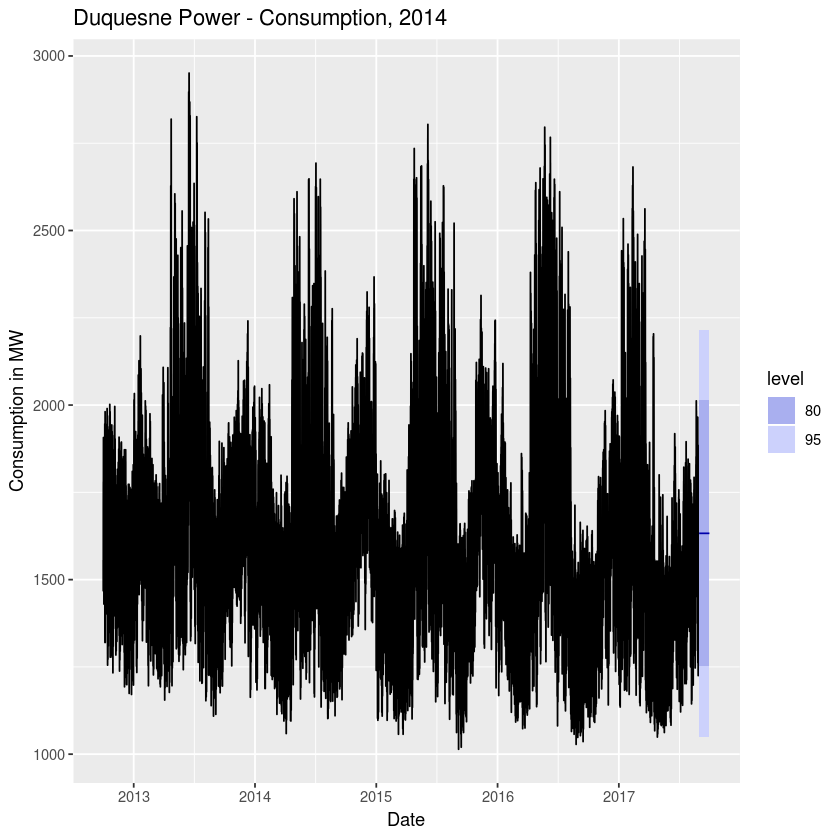

In [7]:
mean_baseline <- meanf(msts_power,h = 24*31)
autoplot(mean_baseline)+geom_line(color = "#00AFBB", size = 0.5) + ggtitle('Duquesne Power - Consumption, 2014')+
    xlab('Date') + ylab('Consumption in MW')
accuracy(mean_baseline,duq_test$DUQ_MW)

I'm going to use the RMSE as the metric to compare different models. The RMSE of the baseline forecast here is 323, and the MAE is 268.8. If my model performs worse than that, all this will not be worth doing at all.

## Forecasting
To deal with multiple seasonalities, the following methods are suggested in the book:
1. TBATS models
2. MSTL - STL decomposition with multiple seasonalities
3. Dynamic harmonic regression with multiple periods
4. Using covariates

I will try these one by one, and then try forecasting using the **prophet** package in R, just to check how well that does.

### 1. TBATS

TBATS is a model combining Exponential Smoothing, Trigonometric Seasonality, Box-Cox transformation and ARMA model for residuals. You can read more about it [here](https://robjhyndman.com/papers/ComplexSeasonality.pdf) or [here](https://yintingchou.com/posts/bats-and-tbats-model/).  

In [8]:
#tbats_power <- tbats(msts_power)
#f_tbats <- forecast(tbats_power, h = 24*31)
#autoplot(f_tbats) +ggtitle('Duquesne Power - Forecast, 2016-17')+
#    xlab('Date') + ylab('Consumption in MW')
#accuracy(f_tbats,duq_test$DUQ_MW)

The TBATS model takes hours to run with this data and my laptop- and gives shit accuracy. I'm commenting it out here. If you *need* to see it in (inaccurate) action, you can do that [here](https://www.kaggle.com/apoorvabhide/energy-consumption-time-series-forecasting-in-r).

The accuracy of that TBATS model is even worse than simply forecasting the mean of the observed values(RMSE = 515.8, MAE = 440.4). That's a bad performance.

### 2. MSTL
MSTL is a modification of the STL decomposition algorithm for multiple seasonalities. The STL algorithm itself works by decomposing the series into three components:
* Seasonal
* Trend
* Remainder

(Or, y = S + T + R, for short.) 

It is based on Loess (local regression) smoothing, which is explained very well [here](https://align-alytics.com/seasonal-decomposition-of-time-series-by-loessan-experiment/). It essentially works by sliding a window over the data, and iteratively fitting a line to the points in the window, updating each time to give more weight to the points closest to the line.

Here's how MSTL works, basically:
1. The inner loop:
    a. Series is 'detrended' by removing whatever the current value of trend is. 
    b. The subseries are smoothed: Basically, if the data has yearly periodicity, the set of all January values, all February values,.. etc are smoothed using the Loess algorithm.
    c. Low pass filter: The data is successively treated with 3 moving averages and again smoothed using Loess.
    d. Detrending (again): The Seasonal component at this point is the difference between outputs of (b) and (c).
    e. Deseasonalising: The current value of Seasonality (S) is subtracted from y.
    f. Smoothing: The data is again smoothed using Loess.
For simplicity, I've excluded the parameters of smoothing and other details.
2. The outer loop: The outer loop calculates what are called 'robustness weights', basically reflecting how extreme a point is according to the current values of S and T.

If you want to learn more, the paper is [well-explained](http://www.nniiem.ru/file/news/2016/stl-statistical-model.pdf).
What the smoothing lets it do is work well even with data having missing points.

Here's how an MSTL model performs on our data:


In [9]:
mstl_power <- mstl(msts_power)

And here's how the series decomposed into trend and seasonality by MSTL looks like:

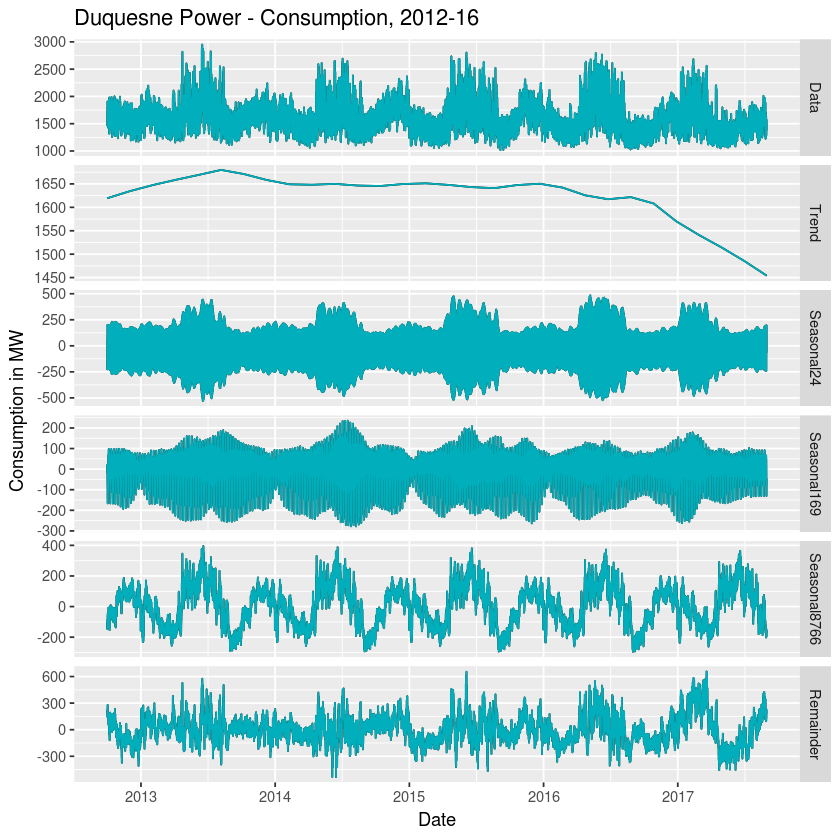

In [10]:
autoplot(mstl_power) +geom_line(color = "#00AFBB") + ggtitle('Duquesne Power - Consumption, 2012-16')+
    xlab('Date') + ylab('Consumption in MW')

Let's check out how well the forecast with MSTL did:

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.00422477,28.69516,18.35723,-0.01897052,1.158136,0.3652333,0.08947889
Test set,126.62689386,375.21951,297.18544,4.53601861,18.502771,5.9127654,NA


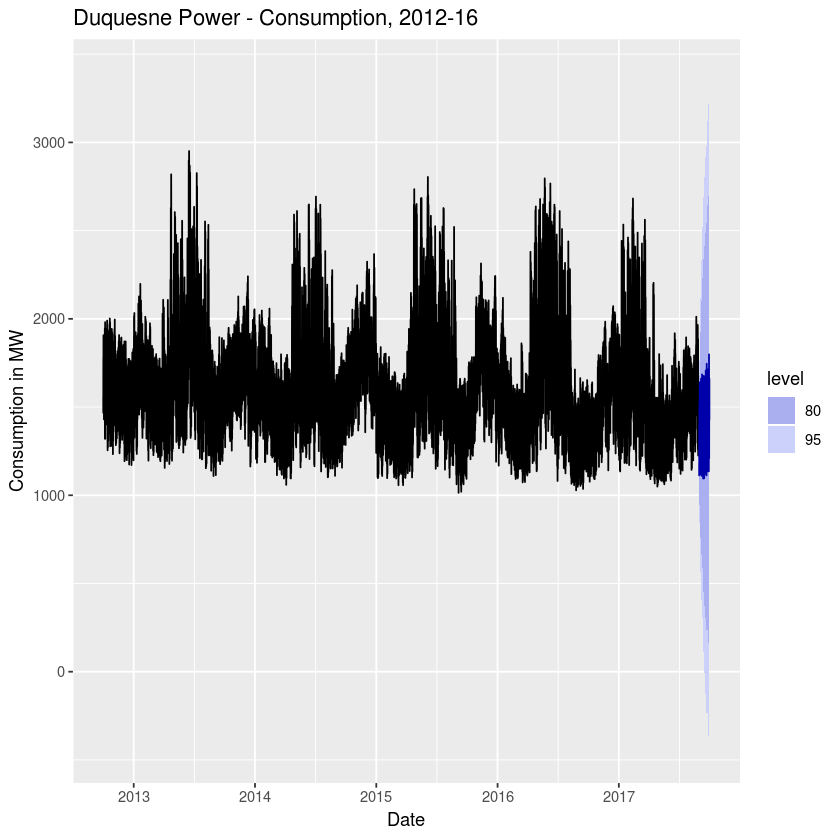

In [11]:
f_mstl <- stlf(msts_power, h = 24*31)
autoplot(f_mstl) +geom_line(color = "#00AFBB") + ggtitle('Duquesne Power - Consumption, 2012-16')+
    xlab('Date') + ylab('Consumption in MW')
accuracy(f_mstl,duq_test$DUQ_MW)

The RMSE of that forecast is 278, and the MAE is 206. That's not bad at all. That's a sizeable improvement over the baseline, and it may even be my best shot with data of hourly frequency.

### 3. Dynamic Harmonic Regression

Another method suggested is to use fourier analysis to predict the incorporate the multiple seasonalities with different frequency. It allows the incorporation of as many frequencies as needed, and the method suggested in FPP2 even uses an ARMA term to take care of the short-term dynamics.

The only drawback as mentioned is that it assumes the frequencies stay constant (because duh, fourier analysis), but I don't think there'll be many problems on that front because the seasonality of power consumption looks constant.

In [12]:
fourier_power <- auto.arima(msts_power, seasonal=FALSE, lambda=0,
         xreg=fourier(msts_power, K=c(10,10,10)))

Let's see how that model performs:

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.3743472,45.05594,29.76963,-0.04183441,1.860402,0.5922929,0.01783161
Test set,218.5081131,461.53608,351.16408,9.80740560,20.937181,6.9867177,NA


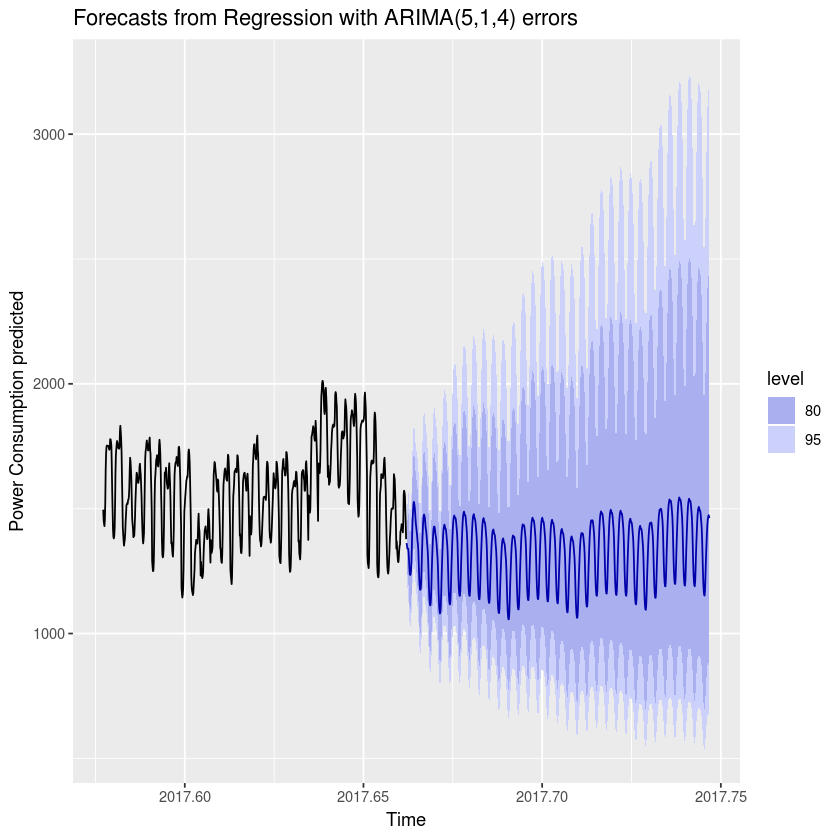

In [13]:
f_fourier <-  forecast(fourier_power, xreg=fourier(msts_power, K=c(10,10,10), h=24*31))
  
autoplot(f_fourier, include=24*31) +
    ylab("Power Consumption predicted") + xlab("Time")

accuracy(f_fourier, duq_test$DUQ)

As the RMSE of 361.5 and MAE of 274.9 suggests, this model performs worse than the baseline. That's not really gonna do!

### 4. Prophet:
I've heard a lot about Facebook's 'Prophet' package. I guess it's time to test it out. Let's see how it does.
For some godforsaken reason, the Prophet package is installed on my system, but this Jupyter notebook has its own force field and can't detect it. At least that's what I'm choosing to believe now, because I don't have any other solutions after three restarts of my R and my system and this notebook. Again, you can go see it [here](https://www.kaggle.com/apoorvabhide/energy-consumption-time-series-forecasting-in-r).

In [1]:
#install.packages('prophet', repos = 'http://cran.us.r-project.org')
library(prophet)
colnames(duq_train) <- c('ds','y')
fit_prophet <- prophet(duq_train)
future_duq <- data.frame(duq_test$Datetime)
colnames(future_duq) <- 'ds'
f_prophet <- predict(fit_prophet,future_duq)
plot(fit_prophet,f_prophet)

ERROR: Error in library(prophet): there is no package called ‘prophet’


Let's look at the series as decomposed by prophet:

In [21]:
prophet_plot_components(fit_prophet,f_prophet)

ERROR: Error in prophet_plot_components(fit_prophet, f_prophet): could not find function "prophet_plot_components"


How well does this model perform?

In [ ]:
rmse <- function(actual, predicted){
  sqrt(mean((actual - predicted)^2))
}
mae <- function(actual,predicted)
{
    error <- actual - predicted
    mean(abs(error))
}
sprintf("The RMSE of the prophet model is: %f",rmse(f_prophet$yhat, duq_test$DUQ_MW))
sprintf("The MAE of the prophet model is: %f",mae(f_prophet$yhat, duq_test$DUQ_MW))

The RMSE is 214.7, and the MAE is around 169. That is very good! Better than all the other models, in fact.

### 5. Covariates
Since this is hourly power consumption, it should be clear that it will depend pretty heavily on the weather conditions in the area - primary power consumption is generally from people's heating and cooling needs, after all. There is, in fact, an hourly weather dataset uploaded right here on Kaggle. It can be found [here](https://www.kaggle.com/selfishgene/historical-hourly-weather-data).

Unfortunately, that data is only available from 2012-17 (hence the subsetting), and has a few missing values. Here's what it looks like, subsetted for Pittsburgh:

In [5]:
pitt <- read.csv('/home/ab/Downloads/Datasets for analysis/hourly-energy-consumption-forecasting/pitt.csv', stringsAsFactors = F)
pitt$datetime <- as.POSIXct(pitt$datetime, '%Y-%m-%d %H:%M:%S', tz = "EDT")
head(pitt,10)

datetime,Pittsburgh
2012-10-01 12:00:00,281.0000
2012-10-01 13:00:00,281.0000
2012-10-01 14:00:00,281.0248
2012-10-01 15:00:00,281.0883
2012-10-01 16:00:00,281.1519
2012-10-01 17:00:00,281.2154
2012-10-01 18:00:00,281.2790
2012-10-01 19:00:00,281.3425
2012-10-01 20:00:00,281.4061
2012-10-01 21:00:00,281.4696


In the original Kaggle kernel, I have removed the three NA values that were present in this dataset. Here, I'll just use it as is.

In [6]:
library(zoo)
#pitt[is.na(pitt$Pittsburgh),]
#pitt$Pittsburgh[pitt$datetime == '2012-10-01 12:00:00'] <- pitt$Pittsburgh[pitt$datetime == '2012-10-01 13:00:00']
#pitt$Pittsburgh <- na.locf(pitt$Pittsburgh)
#head(pitt, 10)


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



To illustrate what I was saying, here's that graph of hourly power consumption for Duquesne in 2014, coupled with the hourly weather in Pittsburgh:

[1] 2


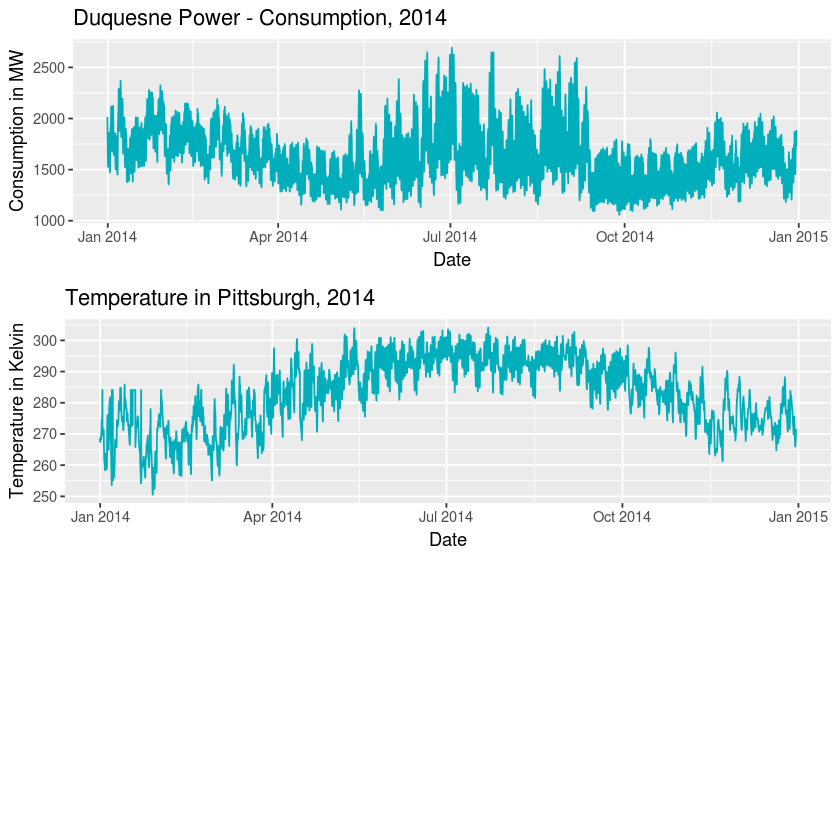

In [7]:
library(ggplot2)
library(ggplot2)
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

power_plot <- ggplot(data = duq[duq$Datetime >= '2014-01-01' & duq$Datetime <= '2014-12-31',], aes(x = Datetime, y = DUQ_MW))+
      geom_line(color = "#00AFBB", size = 0.5) + ggtitle('Duquesne Power - Consumption, 2014')+
    xlab('Date') + ylab('Consumption in MW')
temp_plot <- ggplot(data = pitt[pitt$datetime >= '2014-01-01' & pitt$datetime <= '2014-12-31',], aes(x = datetime, y = Pittsburgh))+
      geom_line(color = "#00AFBB") + ggtitle('Temperature in Pittsburgh, 2014')+
    xlab('Date') + ylab('Temperature in Kelvin')
multiplot(power_plot,temp_plot, nrow = 2)

As you can see, power consumption rises in the summer months, then quiets down a little for Autumn, and then rises again in winter as people need to heat up their homes. Here's a graph of Temperature vs Power Consumption that will make this even clearer:

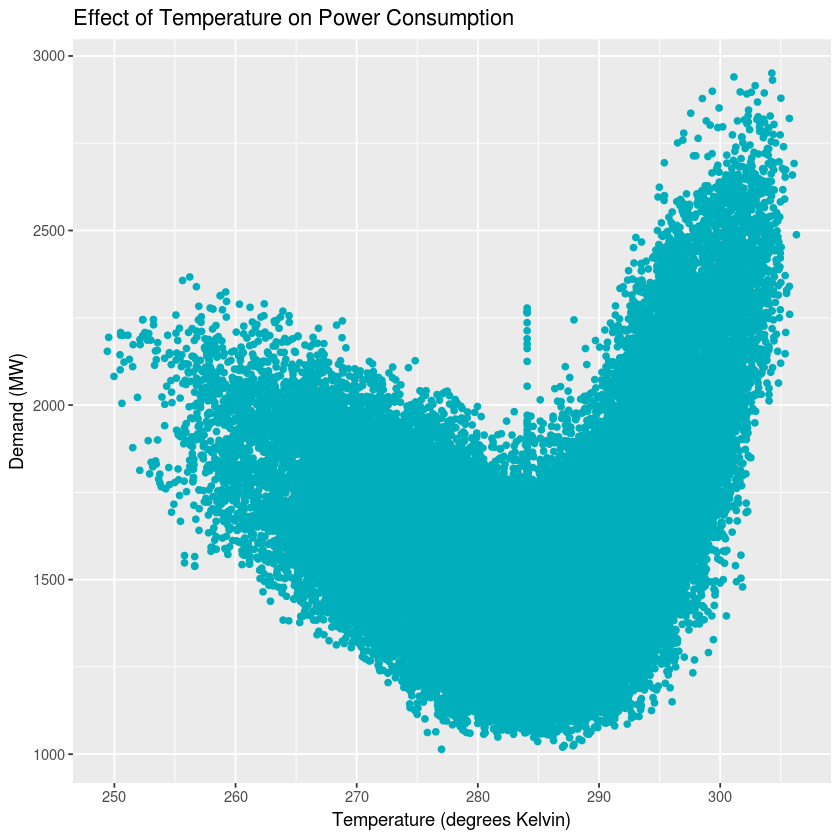

In [8]:
duq_train <- duq[duq$Datetime <= '2017-08-31',]
duq_test <- duq[duq$Datetime >= '2017-09-01',]
pitt_train <- pitt[pitt$datetime <= '2017-08-31',]
pitt_test <- pitt[pitt$datetime >= '2017-09-01',]
temp_power_train <- merge(duq_train, pitt_train, by.x = 'Datetime', by.y = 'datetime')
temp_power_test <- merge(duq_test, pitt_test, by.x = 'Datetime', by.y = 'datetime')
ggplot(data = temp_power_train, aes(x=Pittsburgh, y=DUQ_MW)) + geom_point(color = "#00AFBB") +
    xlab("Temperature (degrees Kelvin)") +
    ylab("Demand (MW)") + ggtitle("Effect of Temperature on Power Consumption")

There is a pretty clear breakpoint near 285K (~12 degrees Celsius) when the power consumption is minimum. If I'm able to fit a piecewise linear function to this data, I should be able to predict the power consumption pretty well.

Now then, I'm going to fit a piecewise linear function to the data using **segmented()**, adding dummy variables for the daily and weekly seasonality. As it turns out, adding a dummy variable for the month or the week is rather unnecessary because the temperature takes care of it.


Datetime,DUQ_MW,Pittsburgh,hour_of_day,day_of_week
2012-10-01 12:00:00,1630,281.0000,17,1
2012-10-01 13:00:00,1640,281.0000,18,1
2012-10-01 14:00:00,1647,281.0248,19,1
2012-10-01 15:00:00,1630,281.0883,20,1
2012-10-01 16:00:00,1627,281.1519,21,1
2012-10-01 17:00:00,1617,281.2154,22,1



	***Regression Model with Segmented Relationship(s)***

Call: 
segmented.lm(obj = lm(DUQ_MW ~ Pittsburgh + hour_of_day + day_of_week, 
    temp_power_train), seg.Z = ~Pittsburgh)

Estimated Break-Point(s):
    Est.  St.Err 
287.733   0.039 

Meaningful coefficients of the linear terms:
               Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   6518.1813    36.3124  179.503  < 2e-16 ***
Pittsburgh     -17.4978     0.1301 -134.450  < 2e-16 ***
hour_of_day01  -25.1405     5.0447   -4.984 6.27e-07 ***
hour_of_day02  -38.7449     5.0448   -7.680 1.62e-14 ***
hour_of_day03  -79.1855     5.0451  -15.696  < 2e-16 ***
hour_of_day04 -159.6660     5.0475  -31.633  < 2e-16 ***
hour_of_day05 -239.2581     5.0535  -47.345  < 2e-16 ***
hour_of_day06 -297.1805     5.0629  -58.698  < 2e-16 ***
hour_of_day07 -328.0672     5.0722  -64.679  < 2e-16 ***
hour_of_day08 -346.2996     5.0825  -68.136  < 2e-16 ***
hour_of_day09 -350.7415     5.0835  -68.996  < 2e-16 ***
hour_of_day10 -333.9849     

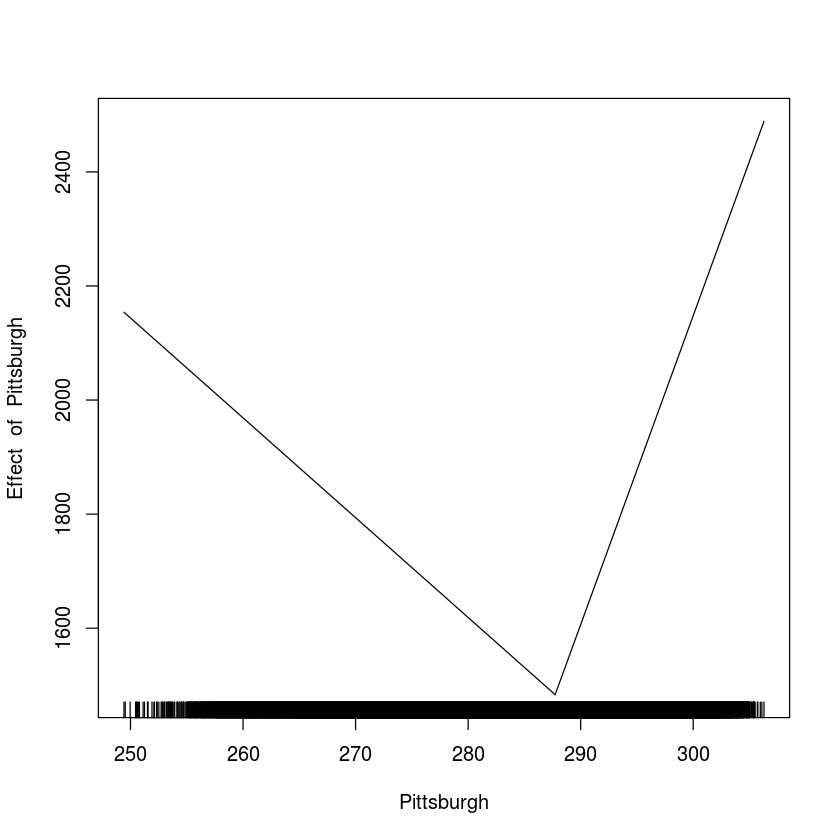

In [9]:
temp_power_train$hour_of_day <- strftime(temp_power_train$Datetime,'%H')
temp_power_train$day_of_week <- strftime(temp_power_train$Datetime,'%u')
head(temp_power_train)
temp_power_test$hour_of_day <- strftime(temp_power_test$Datetime,'%H')
temp_power_test$day_of_week <- strftime(temp_power_test$Datetime, '%u')
library(segmented)
fit_reg <- segmented(lm(DUQ_MW~Pittsburgh+hour_of_day+day_of_week,temp_power_train),seg.Z=~Pittsburgh)
summary(fit_reg)
plot(fit_reg)
predicted_MW <- predict(fit_reg,temp_power_test)

As you can see, the graph changes course at ~288K, around when things start going from hot to cold, and vice versa.
Let's see how well that model performs.

In [10]:
rmse <- function(actual, predicted){
  sqrt(mean((actual - predicted)^2))
}
mae <- function(actual,predicted)
{
    error <- actual - predicted
    mean(abs(error))
}
sprintf('The RMSE for the model is: %f',rmse(predicted_MW, temp_power_test$DUQ_MW))
sprintf('The MAE for the model is: %f',mae(predicted_MW, temp_power_test$DUQ_MW))

[1] "The RMSE for the model is: 163.932948"

[1] "The MAE for the model is: 134.190519"

In [ ]:
write.csv(pitt,'pitt.csv', row.names = FALSE)
write.csv(duq,'duq.csv',row.names = FALSE)

The RMSE is 162.6. The MAE is **134**. Both are about half the baseline errors. That is head and shoulders above all the other models.

## We have a winner!
This was my first proper time series forecasting project, so please feel free to give any feedback/comments.